# AC209B - MS2

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import re
import cv2
import sys

sys.path.insert(0, '../')
from DeepFill.run_preprocessing import deep_fill



## Dataset Description

This dataset, sourced from the UCI ML Repository and originally collected at Children’s Hospital St. Hedwig (2016–2021), contains two components:

1. Tabular data: 782 pediatric cases with 53 clinical features (lab results, symptoms, scores, ultrasound findings) and three target variables (diagnosis, severity, management).

2. Image data: 1709 ultrasound images (B-mode, multiview), with 1–15 views per patient. The primary task is to classify diagnosis (appendicitis vs. no) and offer visually interpretable insights. 

## Tabular Data Loading

### Load

In [17]:
# Load tabular data
app_data = pd.read_csv("../data/app_data.csv")

In [18]:
# Data size
def get_file_size(path='.'):
    total = os.path.getsize(path)
    return total / (1024 * 1024)

print(f"Total dataset size: {get_dir_size('../data/app_data.csv'):.2f} MB")

Total dataset size: 0.18 MB


In [43]:
# Inspect data
app_data.head()
len(app_data.columns)

58

In [52]:
# Keep important variables
target_variables = ["Diagnosis", "Severity", "Management"]
y = app_data[target_variables] #dataframe


feature_variables = ['Age', 'Sex', 'BMI',  # Can influence disease course and treatment decisions
    'Coughing_Pain', 'Psoas_Sign', 'Contralateral_Rebound_Tenderness',  # Physical signs
    'Dysuria', 'Stool',  # May help with differential diagnosis
    'Ketones_in_Urine', 'WBC_in_Urine', 'RBC_in_Urine',  # UTI or confounders
    'Meteorism', 'Enteritis',  # Alternatives to appendicitis
    'Gynecological_Findings',  # Important in adolescent females 
    'Alvarado_Score', 'Paedriatic_Appendicitis_Score', # Scoring Systems
    'Lower_Right_Abd_Pain', 'Migratory_Pain', 'Loss_of_Appetite', 'Nausea', # Key Clinical Signs/Symptoms
    'Peritonitis', 'Body_Temperature',
    'WBC_Count', 'Neutrophil_Percentage', 'CRP', # Lab Values
    'Appendix_on_US', 'Appendix_Diameter', 'Free_Fluids', # Ultrasound Findings
    'Appendix_Wall_Layers', 'Target_Sign',
    'Surrounding_Tissue_Reaction', 
    'Perforation',                # Signals complicated appendicitis → surgery
    'Appendicular_Abscess',       # May lead to conservative mgmt or delayed surgery
    'Perfusion',                  # Reduced perfusion = necrosis = surgery
    'Ileus',                      # Complicated or late-stage
    'Pathological_Lymph_Nodes',   # Possible misdiagnosis or associated findings
    'Bowel_Wall_Thickening',      # Differential diagnosis
    'Coprostasis',                # May contribute to obstruction
    'Conglomerate_of_Bowel_Loops', # Suggestive of post-inflammatory changes
                    ]
x = app_data[feature_variables]

patient_codes_tab = app_data['US_Number']

In [48]:
numerical_variables = [
    'Age', 'BMI', 'Alvarado_Score', 'Paedriatic_Appendicitis_Score',
    'Body_Temperature', 'WBC_Count', 'Neutrophil_Percentage',
    'CRP', 'Appendix_Diameter'
]

categorical_variables = [
    'Stool',  # normal, diarrhea, obstipation
    'Ketones_in_Urine',  # no, +, ++, +++
    'WBC_in_Urine',  # no, +, ++, +++
    'RBC_in_Urine',  # negative, +, ++, +++
    'Peritonitis',  # no, localised, generalised
    'Perfusion'  # unremarkable, hypoperfused, hyperperfused
]

binary_variables = [
    'Sex', 'Coughing_Pain', 'Psoas_Sign', 'Contralateral_Rebound_Tenderness',
    'Dysuria', 'Meteorism', 'Enteritis', 'Lower_Right_Abd_Pain',
    'Migratory_Pain', 'Loss_of_Appetite', 'Nausea', 'Appendix_on_US',
    'Free_Fluids', 'Appendix_Wall_Layers', 'Target_Sign', 'Perforation',
    'Surrounding_Tissue_Reaction', 'Appendicular_Abscess', 'Ileus',
    'Pathological_Lymph_Nodes', 'Bowel_Wall_Thickening', 'Coprostasis',
    'Conglomerate_of_Bowel_Loops'
]

text_variables = ['Gynecological_Findings'] # in german


In our preprocessing, we identified and dropped a number of variables from the original dataset that were either redundant, not informative for modeling, or not relevant to our task:

- Height, Weight, and Length_of_Stay were removed as they do not directly contribute to diagnostic prediction and are not clinically relevant for real-time assessment.

- Diagnosis_Presumptive was excluded to avoid potential data leakage, as it may reflect clinical suspicions closely tied to the final outcome.

- Segmented_Neutrophils, Neutrophilia, and RBC_Count were dropped as their information is already captured in existing features such as WBC_Count, Neutrophil_Percentage, and other lab markers.

- Hemoglobin, RDW, and Thrombocyte_Count were excluded due to their limited diagnostic value for appendicitis in this context.

- Ipsilateral_Rebound_Tenderness was removed due to redundancy with Contralateral_Rebound_Tenderness and overlapping clinical interpretation.

- US_Performed because we match patients with images performed based on their user id below.

- Appendicolith, Abscess_Location, and Lymph_Nodes_Location were dropped due to their free-text nature or lack of standard formatting, which makes consistent interpretation or encoding difficult at this stage. Additionally, these overlap with other binary indicators already included (e.g., Appendicular_Abscess, Pathological_Lymph_Nodes).


## Image Data Loading

### Load 

In [50]:
image_file_list = glob.glob("../data/US_pictures/*")
image_names = []
patient_codes_im = []
for file in image_file_list:
    name = file.split('/')[-1]
    patient_code = re.split('_| |\.', name)[0]
    image_names.append(name)
    patient_codes_im.append(patient_code)
groups = np.array(list(map(int, groups)))
print("Total number of patients having US images: ", len(np.unique(patient_codes_im)))
print("Total number of images: ", len(image_file_list))

Total number of patients having US images:  707
Total number of images:  2097


In [30]:
# Data size
def get_dir_size(path='.'):
    total = 0
    for dirpath, dirnames, filenames in os.walk(path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            total += os.path.getsize(fp)
    return total / (1024 * 1024)

print(f"Total dataset size: {get_dir_size('../data/US_pictures'):.2f} MB")

Total dataset size: 2450.81 MB


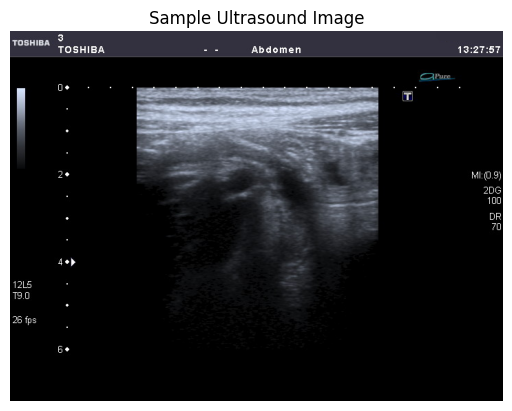

In [35]:
# Inspect data
sample_image_path = image_file_list[0]
img_bgr = cv2.imread(sample_image_path, cv2.IMREAD_COLOR)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.title("Sample Ultrasound Image")
plt.axis('off');

### DeepFill (Annotation & Marker Removal and Filling)

In [75]:
deep_fill('../data/US_pictures', 
         os.path.join('Deepfill_Temp_Dir', 'test'),
         os.path.join('Deepfill_Temp_Dir', 'test_mask'),
         os.path.join('../data', 'US_Pictures_Filled'), 
         "../DeepFill/preproc/patterns")

  0% (1 of 2097) |                       | Elapsed Time: 0:00:00 ETA:   0:03:48



Preparing inpainting...


100% (2097 of 2097) |####################| Elapsed Time: 0:02:41 ETA:  00:00:000113

Applying DeepFill...
Generator is created!
Initialize generator with xavier type
-------------------------Loading Pretrained Model-------------------------


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

### Cropping

## Preprocessing

### Join Tabular and Image Data

### Train and Test Split 

Before further preprocessing to prevent data leakage.

### Missing Data


### Data Imbalance

### Feature Scaling 